In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install ultralytics opencv-python-headless pandas numpy tqdm
!pip install yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.1/182.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 61.1 MB/s eta 0:00:00


In [4]:
import os
import glob

In [5]:
weights_path = "/content/drive/My Drive/UVH-26-MV-YOLOv11-X.pt"

In [6]:
if os.path.exists(weights_path):
    print(f"Weights found at: {weights_path}")
    print(f"File size: {os.path.getsize(weights_path) / (1024*1024):.2f} MB")
else:
    print(f"Weights NOT found at: {weights_path}")
    print("\nSearching for .pt files in your Drive...")
    pt_files = glob.glob("/content/drive/My Drive/**/*.pt", recursive=True)
    if pt_files:
        print("Found these .pt files:")
        for f in pt_files[:5]:  # Show first 5
            print(f"  - {f}")
        weights_path = pt_files[0]  # Use the first one found
        print(f"\nUsing: {weights_path}")
    else:
        print("No .pt files found. Please check the path.")

Weights found at: /content/drive/My Drive/UVH-26-MV-YOLOv11-X.pt
File size: 326.60 MB


In [7]:
import pandas as pd
import time
from ultralytics import YOLO
import numpy as np
from tqdm.notebook import tqdm
import os
from yt_dlp import YoutubeDL

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [12]:
import os
import glob
from google.colab import drive
import cv2
from ipywidgets import interact, widgets, Dropdown
from IPython.display import display

# Function to search for video files in Drive
def find_videos_in_drive():
    video_extensions = ['*.mp4', '*.avi', '*.mov', '*.mkv', '*.flv', '*.wmv']
    video_files = []

    # Search in common locations
    search_paths = [
        "/content/drive/My Drive/",
        "/content/drive/My Drive/Colab Notebooks/",
        "/content/drive/My Drive/Videos/"
    ]

    for path in search_paths:
        for ext in video_extensions:
            video_files.extend(glob.glob(os.path.join(path, "**", ext), recursive=True))

    return video_files

print("Searching for video files in your Google Drive...")
video_files = find_videos_in_drive()

if len(video_files) == 0:
    print("No video files found in common locations.")
    print("Please specify the path manually:")
    manual_path = input("Enter full path to video: ")
    video_files = [manual_path] if os.path.exists(manual_path) else []
else:
    print(f"Found {len(video_files)} video files!")

if len(video_files) > 0:
    # Create a dictionary with readable names
    video_options = {f"Video {i+1}: {os.path.basename(f)}": f for i, f in enumerate(video_files)}

    dropdown = Dropdown(
        options=video_options,
        value=list(video_options.values())[0],
        description='Select Video:',
        style={'description_width': 'initial'},
        layout={'width': '80%'}
    )

    display(dropdown)

    # Button to confirm selection
    select_button = widgets.Button(description="Use Selected Video", button_style='success')
    output = widgets.Output()

    def on_select_clicked(b):
        global video_filename
        video_filename = dropdown.value
        with output:
            output.clear_output()
            print(f"Selected: {video_filename}")

            # Get video info
            cap = cv2.VideoCapture(video_filename)
            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            duration_minutes = frame_count / (fps * 60)
            cap.release()

            print(f"Filename: {os.path.basename(video_filename)}")
            print(f"Duration: {duration_minutes:.2f} minutes")
            print(f"Path: {video_filename}")

    select_button.on_click(on_select_clicked)
    display(select_button, output)

else:
    # Manual fallback
    print("\nPlease enter the path to your video file in Google Drive:")
    print("Example: /content/drive/My Drive/traffic_video.mp4")
    video_filename = input("Video path: ").strip()

    if os.path.exists(video_filename):
        print(f"Video found: {video_filename}")
    else:
        raise FileNotFoundError(f"Video not found at: {video_filename}")

Searching for video files in your Google Drive...
Found 129 video files!


Dropdown(description='Select Video:', layout=Layout(width='80%'), options={'Video 1: Conference System - Brave…

Button(button_style='success', description='Use Selected Video', style=ButtonStyle())

Output()

In [13]:
import ipywidgets as widgets

print("Let's define the locations in your video.")
print("You'll enter start and end times for each location.")

# Interactive location input
locations = []

def add_location(start, end, name):
    if start < end and name.strip():
        locations.append((start, end, name.strip()))
        print(f"Added: {name} ({start}-{end} minutes)")
    else:
        print("Invalid input. Make sure start < end and name is not empty")

# Create input widgets
start_widget = widgets.FloatText(value=0, description='Start (min):', style={'description_width': 'initial'})
end_widget = widgets.FloatText(value=5, description='End (min):', style={'description_width': 'initial'})
name_widget = widgets.Text(value='', description='Location:', placeholder='Enter location name', style={'description_width': 'initial'})
add_button = widgets.Button(description='Add Location', button_style='success')
done_button = widgets.Button(description='Done - Process Video', button_style='info')

output = widgets.Output()

def on_add_clicked(b):
    with output:
        add_location(start_widget.value, end_widget.value, name_widget.value)
        # Clear inputs for next location
        start_widget.value = end_widget.value
        end_widget.value = end_widget.value + 5
        name_widget.value = ''

def on_done_clicked(b):
    with output:
        print("\n" + "=" * 50)
        print("FINAL LOCATION SCHEDULE:")
        print("-" * 50)
        for i, (start, end, name) in enumerate(locations):
            print(f"  {i+1}. {start:5.1f} - {end:5.1f} min: {name}")
        print("=" * 50)
        print("\nReady to process! Run the next cell.")

add_button.on_click(on_add_clicked)
done_button.on_click(on_done_clicked)

display(start_widget, end_widget, name_widget, add_button, done_button, output)


📍 Let's define the locations in your video.
You'll enter start and end times for each location.
--------------------------------------------------


FloatText(value=0.0, description='Start (min):', style=DescriptionStyle(description_width='initial'))

FloatText(value=5.0, description='End (min):', style=DescriptionStyle(description_width='initial'))

Text(value='', description='Location:', placeholder='Enter location name', style=DescriptionStyle(description_…

Button(button_style='success', description='Add Location', style=ButtonStyle())

Button(button_style='info', description='Done - Process Video', style=ButtonStyle())

Output()

In [14]:
import numpy as np
from ultralytics import YOLO
from datetime import datetime, timedelta
from tqdm.notebook import tqdm

def get_location_at_time(minute, locations):
    """Get location name for a given minute"""
    for start, end, name in locations:
        if start <= minute < end:
            return name
    return "Unknown Location"

def count_vehicles_with_locations(video_path, model_path, locations, interval_minutes=1, confidence_threshold=0.25):
    """
    Process video and count vehicles, tagging each interval with location
    """

    # Load model
    print(f"\nLoading YOLO model from Google Drive...")
    model = YOLO(model_path)
    print("Model loaded!")

    # Open video
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    video_duration_min = total_frames / (fps * 60)

    print(f"\nVideo Info:")
    print(f"   FPS: {fps}")
    print(f"   Total Frames: {total_frames}")
    print(f"   Duration: {video_duration_min:.2f} minutes")
    print(f"   Counting interval: {interval_minutes} minute(s)")

    frames_per_interval = fps * 60 * interval_minutes
    num_intervals = int(np.ceil(total_frames / frames_per_interval))
    print(f"   Will generate ~{num_intervals} data points")

    # Initialize data storage
    vehicle_data = []
    frame_count = 0
    interval_count = 0
    frame_counts_buffer = []

    # Process video with progress bar
    pbar = tqdm(total=total_frames, desc="Processing video", unit="frames")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Process every 30th frame to save time
        if frame_count % 30 == 0:
            # Run detection
            results = model(frame, conf=confidence_threshold, verbose=False)

            if results[0].boxes is not None:
                vehicle_count = len(results[0].boxes.cls)
                frame_counts_buffer.append(vehicle_count)

        frame_count += 1
        pbar.update(1)

        # End of interval - save data
        if frame_count % frames_per_interval == 0 or frame_count == total_frames:
            if frame_counts_buffer:
                # Calculate average count for this interval
                avg_count = int(np.mean(frame_counts_buffer))

                # Calculate current time in video
                current_minute = interval_count * interval_minutes

                # Get location for this time
                location = get_location_at_time(current_minute, locations)

                # Create timestamp (using relative time)
                timestamp = (datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
                           + timedelta(minutes=interval_count * interval_minutes))

                # Store data
                vehicle_data.append({
                    'timestamp': timestamp.strftime('%Y-%m-%d %H:%M:%S'),
                    'video_minute': round(current_minute, 1),
                    'vehicle_count': avg_count,
                    'location': location,
                    'samples_in_interval': len(frame_counts_buffer)
                })

                # Clear buffer
                frame_counts_buffer = []
                interval_count += 1

                # Show progress every 10 intervals
                if interval_count % 10 == 0:
                    print(f"\n   Minute {current_minute}: {avg_count} vehicles at {location[:30]}...")

    pbar.close()
    cap.release()

    # Create DataFrame
    df = pd.DataFrame(vehicle_data)
    return df

In [15]:
if len(locations) == 0:
    print("No locations defined! Using default location.")
    locations = [(0, 1000, "Main Road")]

# Run the counting function
print("Starting vehicle counting with location tracking...")

df_vehicle_counts = count_vehicles_with_locations(
    video_path=video_filename,
    model_path=weights_path,
    locations=locations,
    interval_minutes=1,  # Count every minute
    confidence_threshold=0.25  # Adjust if needed
)

print("Counting complete!")
print(f"Total intervals recorded: {len(df_vehicle_counts)}")

# Display sample
print("\n📋 First 10 intervals:")
print(df_vehicle_counts[['timestamp', 'video_minute', 'vehicle_count', 'location']].head(10).to_string())


Starting vehicle counting with location tracking...

🔄 Loading YOLO model from Google Drive...
✅ Model loaded!

📹 Video Info:
   FPS: 30
   Total Frames: 27005
   Duration: 15.00 minutes
   Counting interval: 1 minute(s)
   Will generate ~16 data points


Processing video:   0%|          | 0/27005 [00:00<?, ?frames/s]


   Minute 9: 7 vehicles at B...

Counting complete!
Total intervals recorded: 15

📋 First 10 intervals:
             timestamp  video_minute  vehicle_count location
0  2026-02-26 00:00:00             0             59        A
1  2026-02-26 00:01:00             1             60        A
2  2026-02-26 00:02:00             2             58        A
3  2026-02-26 00:03:00             3             63        A
4  2026-02-26 00:04:00             4             58        A
5  2026-02-26 00:05:00             5             10        B
6  2026-02-26 00:06:00             6              6        B
7  2026-02-26 00:07:00             7              7        B
8  2026-02-26 00:08:00             8              8        B
9  2026-02-26 00:09:00             9              7        B


In [16]:
now = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save full data CSV
csv_filename = f"traffic_data_{now}.csv"
df_vehicle_counts.to_csv(csv_filename, index=False)
print(f"Full data saved to: {csv_filename}")

# Save simplified version for LSTM (just timestamp, count, location)
lstm_filename = f"lstm_ready_{now}.csv"
df_vehicle_counts[['timestamp', 'vehicle_count', 'location']].to_csv(lstm_filename, index=False)
print(f"LSTM-ready CSV saved to: {lstm_filename}")

# Save to Google Drive
drive_folder = "/content/drive/My Drive/Colab Notebooks/traffic_results/"
os.makedirs(drive_folder, exist_ok=True)

drive_csv = f"{drive_folder}traffic_data_{now}.csv"
df_vehicle_counts.to_csv(drive_csv, index=False)
print(f"Also saved to Google Drive: {drive_csv}")

# Download to local machine
from google.colab import files
print("\nDownloading files...")
files.download(lstm_filename)

# Preview the CSV
print("\nCSV Preview (first 5 rows):")
print(df_vehicle_counts[['timestamp', 'vehicle_count', 'location']].head().to_string())

Full data saved to: traffic_data_20260226_093105.csv
LSTM-ready CSV saved to: lstm_ready_20260226_093105.csv
Also saved to Google Drive: /content/drive/My Drive/Colab Notebooks/traffic_results/traffic_data_20260226_093105.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


CSV Preview (first 5 rows):
             timestamp  vehicle_count location
0  2026-02-26 00:00:00             59        A
1  2026-02-26 00:01:00             60        A
2  2026-02-26 00:02:00             58        A
3  2026-02-26 00:03:00             63        A
4  2026-02-26 00:04:00             58        A



📊 TRAFFIC STATISTICS BY LOCATION:
         vehicle_count                    
                 count  mean max min   std
location                                  
A                    5  59.6  63  58  2.07
B                    5   7.6  10   6  1.52
C                    5   7.8  10   6  1.64


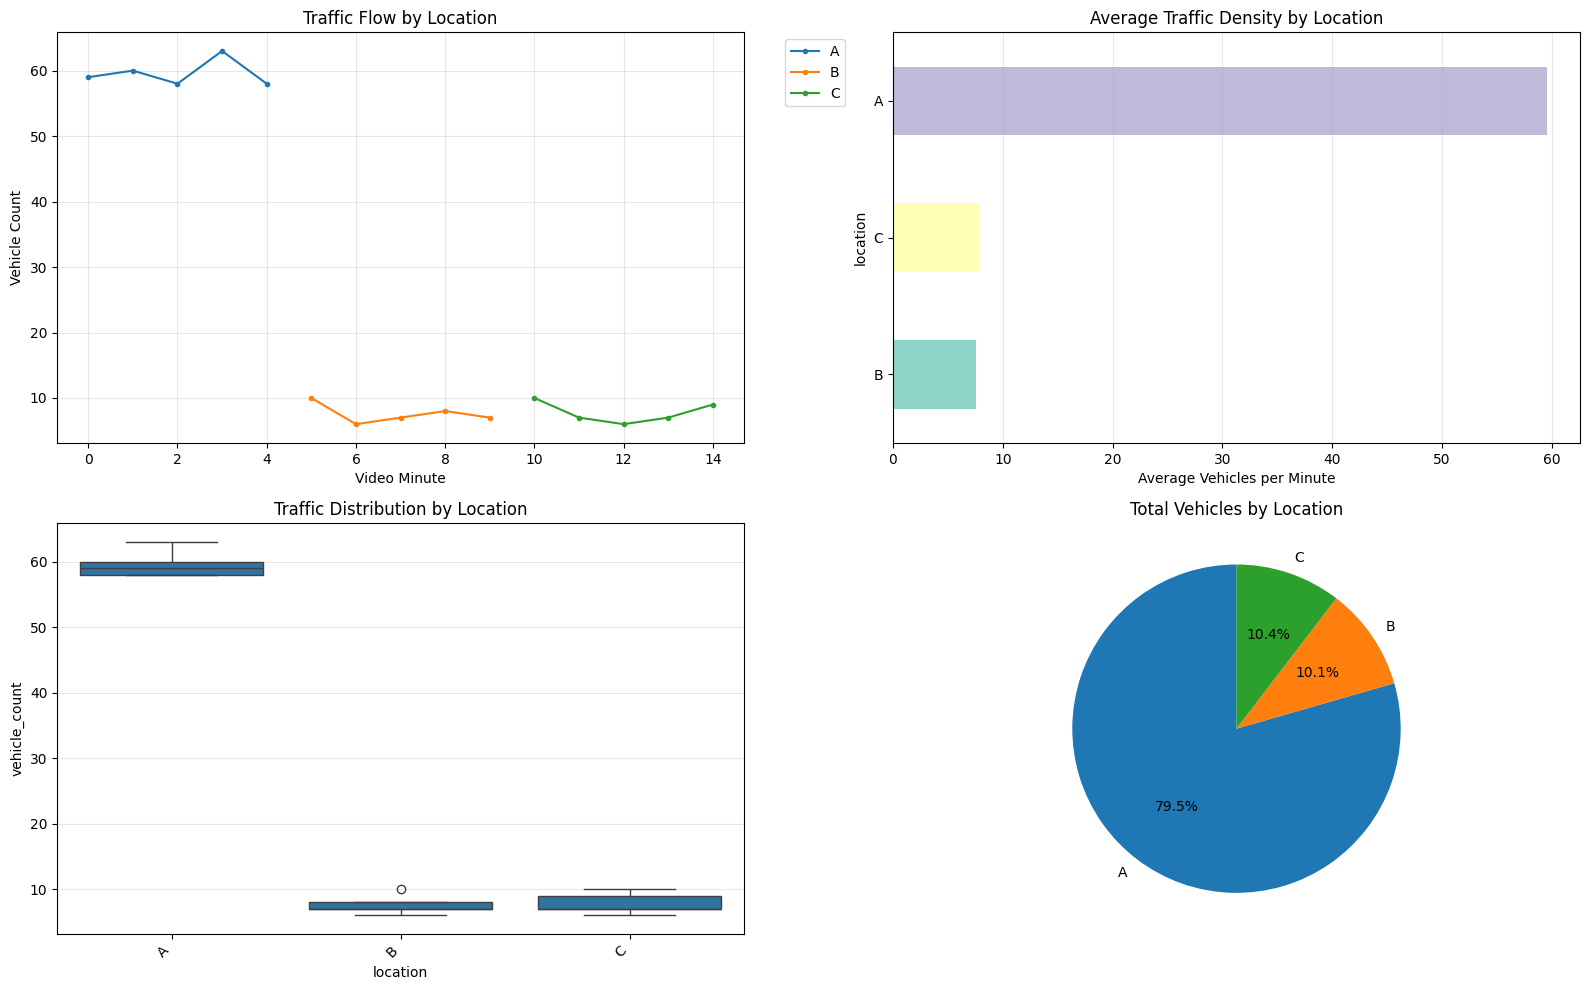

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics by location
print("\nTRAFFIC STATISTICS BY LOCATION:")

location_stats = df_vehicle_counts.groupby('location').agg({
    'vehicle_count': ['count', 'mean', 'max', 'min', 'std']
}).round(2)

print(location_stats)

# Visualizations
plt.figure(figsize=(16, 10))

# 1. Time series with location colors
plt.subplot(2, 2, 1)
for location in df_vehicle_counts['location'].unique():
    loc_data = df_vehicle_counts[df_vehicle_counts['location'] == location]
    plt.plot(loc_data['video_minute'], loc_data['vehicle_count'],
             marker='.', linestyle='-', label=location[:25])
plt.xlabel('Video Minute')
plt.ylabel('Vehicle Count')
plt.title('Traffic Flow by Location')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 2. Average by location (bar chart)
plt.subplot(2, 2, 2)
avg_by_loc = df_vehicle_counts.groupby('location')['vehicle_count'].mean().sort_values()
colors = plt.cm.Set3(range(len(avg_by_loc)))
avg_by_loc.plot(kind='barh', color=colors)
plt.xlabel('Average Vehicles per Minute')
plt.title('Average Traffic Density by Location')
plt.grid(True, alpha=0.3, axis='x')

# 3. Box plot by location
plt.subplot(2, 2, 3)
sns.boxplot(data=df_vehicle_counts, x='location', y='vehicle_count')
plt.xticks(rotation=45, ha='right')
plt.title('Traffic Distribution by Location')
plt.grid(True, alpha=0.3, axis='y')

# 4. Pie chart of total vehicles by location
plt.subplot(2, 2, 4)
total_by_loc = df_vehicle_counts.groupby('location')['vehicle_count'].sum()
plt.pie(total_by_loc.values, labels=total_by_loc.index, autopct='%1.1f%%', startangle=90)
plt.title('Total Vehicles by Location')

plt.tight_layout()
plt.show()

In [18]:
print("Creating location-specific CSV files:")
print("-" * 40)

# Create folder for location CSVs
loc_folder = f"/content/drive/My Drive/Colab Notebooks/traffic_results/locations_{now}/"
os.makedirs(loc_folder, exist_ok=True)

for location in df_vehicle_counts['location'].unique():
    loc_data = df_vehicle_counts[df_vehicle_counts['location'] == location]

    # Create safe filename
    loc_name = location.replace(' ', '_').replace('-', '_').replace(',', '')
    loc_name = ''.join(c for c in loc_name if c.isalnum() or c == '_')

    # Save location-specific CSV
    loc_csv = f"{loc_folder}{loc_name}_traffic.csv"
    loc_data[['timestamp', 'video_minute', 'vehicle_count']].to_csv(loc_csv, index=False)

    print(f"{loc_name}: {len(loc_data)} minutes, avg: {loc_data['vehicle_count'].mean():.1f} veh/min")

print(f"\nAll location CSVs saved to: {loc_folder}")


Creating location-specific CSV files:
----------------------------------------
A: 5 minutes, avg: 59.6 veh/min
B: 5 minutes, avg: 7.6 veh/min
C: 5 minutes, avg: 7.8 veh/min

All location CSVs saved to: /content/drive/My Drive/Colab Notebooks/traffic_results/locations_20260226_093105/


In [21]:

import cv2

try:
    # Try to get from existing variable
    duration_minutes
except NameError:
    print("Calculating video duration...")
    # Open video and calculate duration
    cap = cv2.VideoCapture(video_filename)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration_minutes = frame_count / (fps * 60)
    cap.release()
    print(f"Video duration: {duration_minutes:.2f} minutes")

📹 Calculating video duration...
✅ Video duration: 15.00 minutes


In [22]:
from datetime import datetime
report = f"""
==================================================
TRAFFIC ANALYSIS SUMMARY REPORT
==================================================

Video File: {video_filename}
Video Duration: {duration_minutes:.2f} minutes
Date Processed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Total Intervals: {len(df_vehicle_counts)} minutes

LOCATION BREAKDOWN:
{'-' * 50}
"""

for location in df_vehicle_counts['location'].unique():
    loc_data = df_vehicle_counts[df_vehicle_counts['location'] == location]
    report += f"""
{location}:
  • Duration: {len(loc_data)} minutes
  • Average: {loc_data['vehicle_count'].mean():.1f} vehicles/min
  • Peak: {loc_data['vehicle_count'].max()} vehicles
  • Minimum: {loc_data['vehicle_count'].min()} vehicles
  • Std Dev: {loc_data['vehicle_count'].std():.1f}
"""

report += f"""
{'-' * 50}

OVERALL STATISTICS:
• Total vehicles counted: {df_vehicle_counts['vehicle_count'].sum():,}
• Overall average: {df_vehicle_counts['vehicle_count'].mean():.1f} vehicles/min
• Busiest location: {df_vehicle_counts.groupby('location')['vehicle_count'].mean().idxmax()}
• Quietest location: {df_vehicle_counts.groupby('location')['vehicle_count'].mean().idxmin()}
• Peak traffic moment: Minute {df_vehicle_counts.loc[df_vehicle_counts['vehicle_count'].idxmax(), 'video_minute']}
  ({df_vehicle_counts['vehicle_count'].max()} vehicles)

==================================================
"""

print(report)

# Save report
report_filename = f"traffic_report_{now}.txt"
with open(report_filename, 'w') as f:
    f.write(report)

# Also save to Drive
drive_report = f"{drive_folder}traffic_report_{now}.txt"
with open(drive_report, 'w') as f:
    f.write(report)

print(f"Report saved to: {drive_report}")

# Download report
files.download(report_filename)


TRAFFIC ANALYSIS SUMMARY REPORT

Video File: /content/drive/My Drive/traffic_video.mp4
Video Duration: 15.00 minutes
Date Processed: 2026-02-26 09:33:53
Total Intervals: 15 minutes

LOCATION BREAKDOWN:
--------------------------------------------------

A:
  • Duration: 5 minutes
  • Average: 59.6 vehicles/min
  • Peak: 63 vehicles
  • Minimum: 58 vehicles
  • Std Dev: 2.1

B:
  • Duration: 5 minutes
  • Average: 7.6 vehicles/min
  • Peak: 10 vehicles
  • Minimum: 6 vehicles
  • Std Dev: 1.5

C:
  • Duration: 5 minutes
  • Average: 7.8 vehicles/min
  • Peak: 10 vehicles
  • Minimum: 6 vehicles
  • Std Dev: 1.6

--------------------------------------------------

OVERALL STATISTICS:
• Total vehicles counted: 375
• Overall average: 25.0 vehicles/min
• Busiest location: A
• Quietest location: B
• Peak traffic moment: Minute 3 
  (63 vehicles)


Report saved to: /content/drive/My Drive/Colab Notebooks/traffic_results/traffic_report_20260226_093105.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
print("Data Quality Check:")

# Check for missing values
missing = df_vehicle_counts.isnull().sum().sum()
print(f"  Missing values: {missing}")

# Check time coverage
expected_minutes = int(duration_minutes)
actual_minutes = len(df_vehicle_counts)
print(f"  Expected minutes: {expected_minutes}")
print(f"  Actual minutes: {actual_minutes}")
print(f"  Coverage: {actual_minutes/expected_minutes*100:.1f}%")

# Check if all locations are covered
print(f"  Locations found: {len(df_vehicle_counts['location'].unique())}")
print(f"  Locations defined: {len(locations)}")

if actual_minutes > 0:
    print(f"\nData looks good! Ready for LSTM training.")
    print(f"   Your CSV file '{lstm_filename}' has {actual_minutes} rows of data.")
else:
    print("No data generated. Please check your video and settings.")

🔍 Data Quality Check:
------------------------------
  Missing values: 0
  Expected minutes: 15
  Actual minutes: 15
  Coverage: 100.0%
  Locations found: 3
  Locations defined: 3

Data looks good! Ready for LSTM training.
   Your CSV file 'lstm_ready_20260226_093105.csv' has 15 rows of data.
